In [1]:
import os
os.chdir("..")

In [2]:
from src.data.utils import DiffReg
import geopandas as gpd

dr = DiffReg()

In [4]:
gdf = dr.pull_county_shapes()

In [36]:
gdf = gdf[gdf["fips"] == "72"].reset_index(drop=True)
gdf

,geo_id,fips,county_name,geometry,area_fips
0,72085,72,Las Piedras,"POLYGON ((-7331170.933 2043519.576, -7331204.2...",72085
1,72115,72,Quebradillas,"POLYGON ((-7454338.492 2079457.475, -7454328.2...",72115
2,72105,72,Naranjito,"POLYGON ((-7370792.323 2059852.113, -7370786.6...",72105
3,72053,72,Fajardo,"POLYGON ((-7310899.209 2057344.929, -7310880.8...",72053
4,72151,72,Yabucoa,"POLYGON ((-7324477.738 2032476.081, -7324469.3...",72151
...,...,...,...,...,...
73,72101,72,Morovis,"POLYGON ((-7392979.188 2054966.227, -7393291.7...",72101
74,72083,72,Las Marías,"POLYGON ((-7459169.09 2056847.235, -7459159.85...",72083
75,72059,72,Guayanilla,"POLYGON ((-7433262.818 2023459.358, -7433413.0...",72059
76,72131,72,San Sebastián,"POLYGON ((-7447910.793 2067119.065, -7447898.2...",72131


In [ ]:
df = dr.base_data()
df

In [ ]:
dr.make_spatial_table()

In [25]:
gdf2 = gpd.read_file("data/external/zips_shape.zip").to_crs("EPSG:3395")

In [37]:
gdf2[gdf2["ZCTA5CE20"] == "00680"]

,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
13720,00680,00680,860Z200US00680,B5,G6350,S,166550170,19822248,+18.1834927,-067.1330541,"MULTIPOLYGON (((-7475261.769 2045008.555, -747..."


<Axes: >

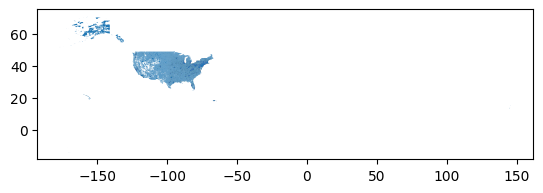

In [ ]:
gdf2[gdf2["GEOIDFQ20"].str.startswith("86")]

In [29]:
gdf

,geo_id,fips,county_name,geometry,area_fips
5,72085,72,Las Piedras,"POLYGON ((-7331170.933 2043519.576, -7331204.2...",72085
80,72115,72,Quebradillas,"POLYGON ((-7454338.492 2079457.475, -7454328.2...",72115
204,72105,72,Naranjito,"POLYGON ((-7370792.323 2059852.113, -7370786.6...",72105
255,72053,72,Fajardo,"POLYGON ((-7310899.209 2057344.929, -7310880.8...",72053
259,72151,72,Yabucoa,"POLYGON ((-7324477.738 2032476.081, -7324469.3...",72151
...,...,...,...,...,...
2754,72101,72,Morovis,"POLYGON ((-7392979.188 2054966.227, -7393291.7...",72101
2787,72083,72,Las Marías,"POLYGON ((-7459169.09 2056847.235, -7459159.85...",72083
2831,72059,72,Guayanilla,"POLYGON ((-7433262.818 2023459.358, -7433413.0...",72059
2832,72131,72,San Sebastián,"POLYGON ((-7447910.793 2067119.065, -7447898.2...",72131


In [27]:
from geopandas.tools import sjoin

In [ ]:
zip_with_county = gpd.sjoin(gdf2, gdf[['geometry', 'county_fips']], how='inner', predicate='intersects')

<Axes: >

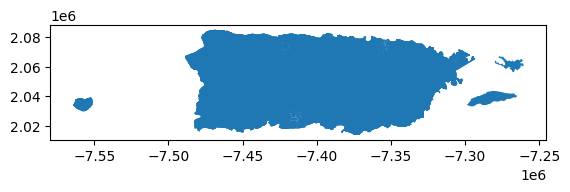

In [39]:
zip_with_county[zip_with_county["geo_id"] == "72151"]

,ZCTA5CE20,GEOID20,GEOIDFQ20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,index_right,geo_id
13482,00791,00791,860Z200US00791,B5,G6350,S,110427972,4704681,+18.1426026,-065.8128118,"POLYGON ((-7333477.919 2039150.745, -7333474.2...",4,72151
13670,00754,00754,860Z200US00754,B5,G6350,S,129481142,241011,+18.1445820,-065.9722534,"POLYGON ((-7352956.937 2037561.849, -7352765.1...",4,72151
13674,00707,00707,860Z200US00707,B5,G6350,S,54196287,3816672,+18.0140550,-065.9207506,"POLYGON ((-7345739.538 2030731.65, -7345727.40...",4,72151
13675,00723,00723,860Z200US00723,B5,G6350,S,119158940,17449667,+18.0193366,-066.0018621,"POLYGON ((-7357035.906 2030890.503, -7356686.5...",4,72151
13852,00767,00767,860Z200US00767,B5,G6350,S,142912279,6804946,+18.0694892,-065.8960286,"POLYGON ((-7348298.328 2032319.31, -7348294.54...",4,72151
13860,00771,00771,860Z200US00771,B5,G6350,S,87025384,32338,+18.1871483,-065.8711890,"POLYGON ((-7339109.349 2040976.71, -7338909.75...",4,72151
